In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import numpy as np
import pandas as pd
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # for os error image file truncated

In [2]:
root='/kaggle/input/paintings-image-classification/data/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
1968,/kaggle/input/paintings-image-classification/data/Landscape/bcfa5340-a64a-410b-a322-58d18d03100b.jpg,Landscape
1331,/kaggle/input/paintings-image-classification/data/Portrait/e56ed8e3-01ba-45be-a71c-11f8c58f3d94.jpg,Portrait
1873,/kaggle/input/paintings-image-classification/data/Landscape/55615311-7637-4245-8db1-45f2faf23fef.jpg,Landscape
1200,/kaggle/input/paintings-image-classification/data/Portrait/d19875e5-03f0-46e4-9413-0148e194d604.JPG,Portrait
351,/kaggle/input/paintings-image-classification/data/Still Life/18688936-84e8-490e-b53d-7de27c6ca4c8.jpg,Still Life
...,...,...
597,/kaggle/input/paintings-image-classification/data/Abstract/6e8e5e71-9e79-418a-9904-40610df536ac.jpg,Abstract
136,/kaggle/input/paintings-image-classification/data/Pop Art/394a1eec-3d46-43c2-b8f5-48d2f906ba70.jpg,Pop Art
1864,/kaggle/input/paintings-image-classification/data/Landscape/447f355b-f87d-4456-af4c-7707d3f9e718.JPG,Landscape
1741,/kaggle/input/paintings-image-classification/data/Surrealist/de0ac92b-639c-4b76-baeb-668ec691961b.jpg,Surrealist


# Deleting corrupt files

In [3]:
data.reset_index(inplace = True, drop = True)
prev=len(data)
corrupt=[]
for i in range(len(data)):
    try:
        im = Image.open(data.iloc[i].path)
    except:
        corrupt.append(i)
data=data.drop(corrupt)
train=data
print("deleted:",prev-len(data))

deleted: 51


# Dataloaders

In [4]:
dblock= DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('path'), 
    get_y=ColReader('class_'), 
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.08),
)

In [5]:
dataloader=dblock.dataloaders(train, bs=8)

In [6]:
torch.save(dataloader, "dataloaderv1.pkl")

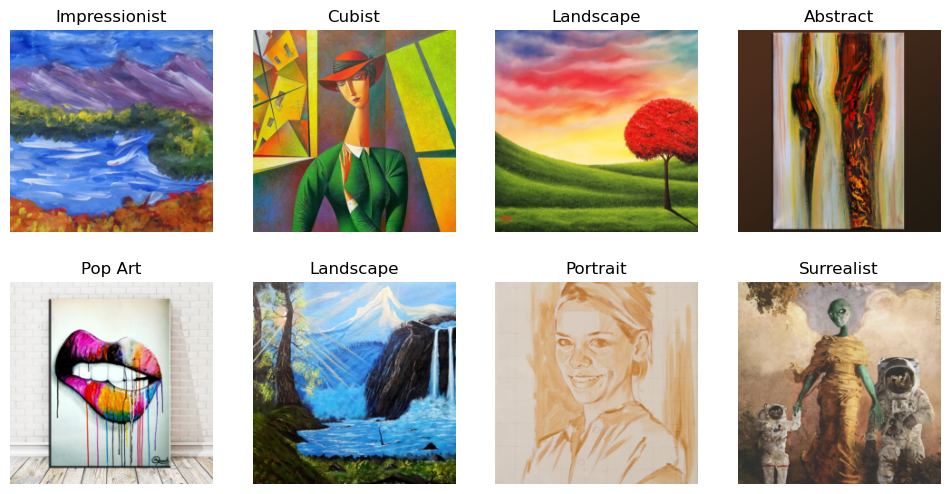

In [7]:
dataloader.train.show_batch(max_n=8, nrows=2)

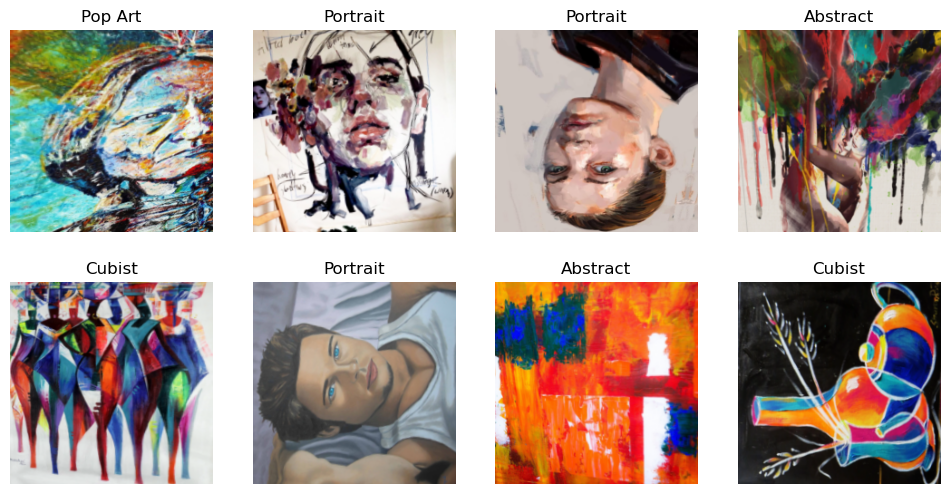

In [8]:
dblock = dblock.new(item_tfms=Resize(224, ResizeMethod.Squish), batch_tfms=aug_transforms(do_flip=True,
                                                                                         flip_vert=True,
                                                                                          max_rotate=10,
                                                                                          max_lighting=0.1,
                                                                                         )) 
dls = dblock.dataloaders(train)
dls.train.show_batch(max_n=8, nrows=2)

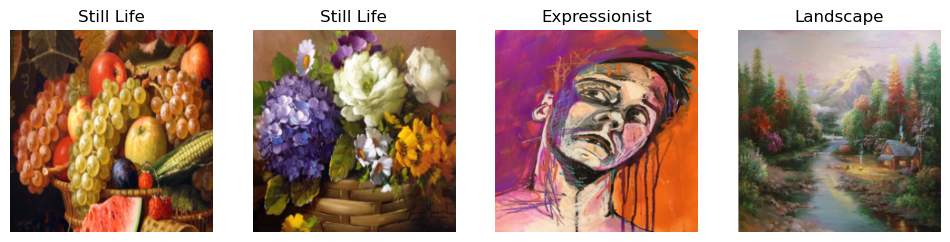

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

# Model Construction

In [10]:
model = cnn_learner(dls, densenet201, metrics=[error_rate,accuracy])

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet

In [11]:
model.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.055464,2.062994,0.725490,0.274510,01:37
1,2.128468,1.333031,0.470588,0.529412,01:40
2,1.607973,1.168918,0.385621,0.614379,01:41
3,1.291444,1.137148,0.333333,0.666667,01:40
4,1.055753,1.393208,0.366013,0.633987,01:40
5,0.875877,1.251487,0.300654,0.699346,01:41
6,0.725266,1.398680,0.326797,0.673203,01:41
7,0.591490,1.223992,0.326797,0.673203,01:43
8,0.505575,1.174479,0.326797,0.673203,01:39
9,0.429724,1.284109,0.352941,0.647059,01:40


# validation

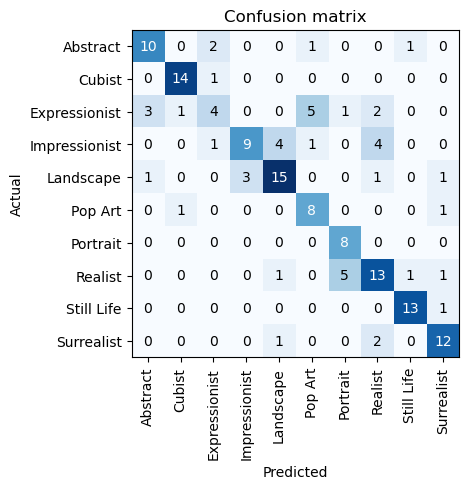

In [12]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

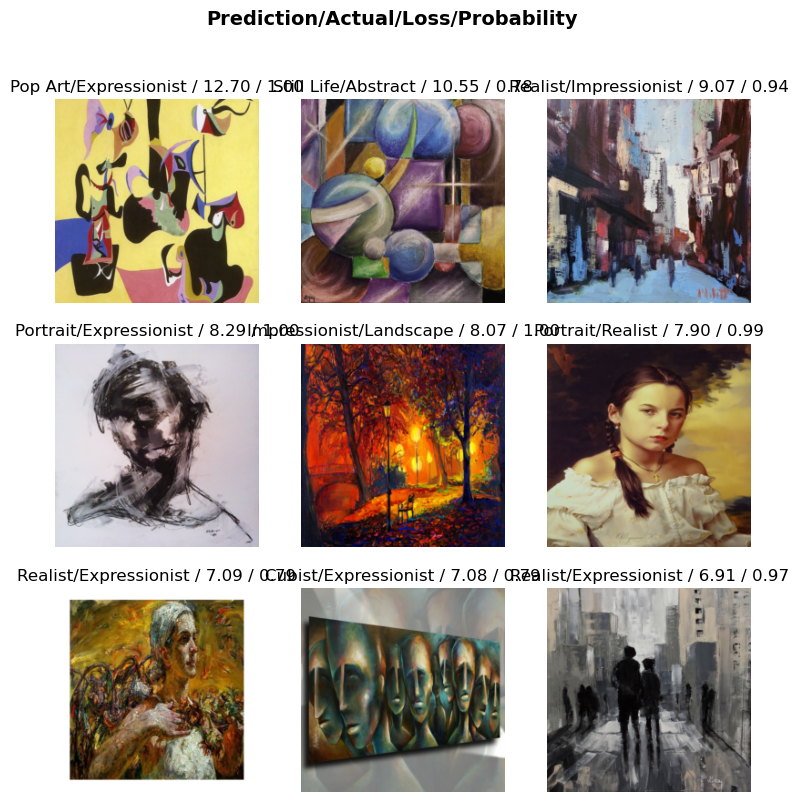

In [13]:
interp.plot_top_losses(9, nrows=3)

In [14]:
model.save('modelv1')

Path('models/modelv1.pth')